***
# <font color=green size=10>Lista 2: Inferência estatística via simulação</font>
***

Universidade de Brasília/PPCA

Métodos Computacionais Intensivos para Mineração de Dados

Prof. Guilherme Souza Rodrigues

Aluno: Paulo Célio Soares da Silva Júnior - 22/0005605

**Importando bibliotecas.**

In [1]:
from scipy.stats import poisson
from scipy.optimize import minimize

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

**Definindo constantes globais.**

In [2]:
# Valor da semente padrão
SEED = 42
N = 10000

**Montando o dataset da lista.**

In [3]:
# Carrega os arquivos csv originais
climbing_statistics = pd.read_csv("climbing_statistics.csv")
rainier_weather = pd.read_csv("Rainier_Weather.csv")

# Junta os arquivos, elimina linhas e colunas desnecessárias e renomeia colunas
dados = climbing_statistics.merge(rainier_weather)
dados = dados.drop(["Success Percentage", "Battery Voltage AVG"], axis=1)
dados = dados.query("Attempted >= Succeeded")
dados = dados.rename(columns={"Date": "Data", "Succeeded": "Sucessos", "Attempted": "Tentativas",
                              "Temperature AVG": "Temperatura", "Relative Humidity AVG": "Umidade_relativa",
                              "Wind Speed Daily AVG": "Velocidade_vento", "Wind Direction AVG": "Direc_vento",
                              "Solare Radiation AVG": "Radiacao_solar"})

# Aplica as transformações nos dados
dados.Temperatura = (dados.Temperatura - 32) * 5 / 9
dados["Cleaver"] = dados.Route == "Disappointment Cleaver"
dados.Data = pd.to_datetime(dados.Data)

# Reordena as colunas de acordo com o layout definido para a lista
dados = dados.reindex(columns=["Data", "Sucessos", "Route", "Tentativas", "Temperatura", "Umidade_relativa",
                               "Velocidade_vento", "Direc_vento", "Radiacao_solar", "Cleaver"])

___

## Contextualização

"O Monte Rainier é um estratovulcão, e a montanha mais alta do estado norte-americano de Washington.(. . . ) Sua altitude é de 4392m e, em dias de tempo claro, seu pico permanentemente nevado pode ser facilmente avistado de Seattle e outras cidades da região." (*wikipédia*)

Um conjunto de dados sobre tentativas de se escalar o Monte Rainier está disponível no site *Kaggle*, e pode ser obtido pelo link [https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data/version/3](https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data/version/3).

Usaremos Modelos Lineares Generalizados para descrever como o número de montanhistas que alcançam o cume do monte em um dado dia (sucessos) varia em função da temperatura média do ar (em graus Celsius).

A seguir apresentamos a estrutura do banco de dados.

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1889 entries, 0 to 1894
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Data              1889 non-null   datetime64[ns]
 1   Sucessos          1889 non-null   int64         
 2   Route             1889 non-null   object        
 3   Tentativas        1889 non-null   int64         
 4   Temperatura       1889 non-null   float64       
 5   Umidade_relativa  1889 non-null   float64       
 6   Velocidade_vento  1889 non-null   float64       
 7   Direc_vento       1889 non-null   float64       
 8   Radiacao_solar    1889 non-null   float64       
 9   Cleaver           1889 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 149.4+ KB


Considere o modelo $$Y_{ij} \sim Poisson(\lambda_{ij})\\ \lambda_{ij} = exp(\alpha + \beta t_{i}),$$

onde $Y_{ij}$ representa o número de montanhistas que atingiram o cume pela rota $j$ no dia $i$, $\alpha$ e $\beta$ são parâmetros desconhecidos do modelo e $t_{i}$ indica a temperatura média no dia $i$. Para uma determinada temperatura, o modelo prevê o mesmo valor para todas as rotas. Desconsidere os dados da rota *glacier only - no summit attempt*. Por fim, note que para obter o valor de $y_{ij}$ é preciso somar todos os sucessos registrados no dia $i$ para a rota $j$.

In [5]:
# Desconsidera os dados da rota "glacier only - no summit attempt"
dados = dados.query("Route != 'glacier only - no summit attempt'")

## Questão 1)

### a)

___

Conduza um teste de hipóteses por simulação para avaliar a hipótese nula de que a média do número de sucessos obtidos pela rota "Disappointment Cleaver" é igual a média das demais rotas (conjuntamente).


Separando os dois grupos (rota Disappointment Cleaver e demais rotas) e calculando suas médias e quantidades.

In [6]:
# Agrega os dados
cleaver_agg = dados.groupby(["Cleaver"]).agg({"Sucessos": ["mean", "count"]})

# Obtem médias, quantidades e diferença entre as médias
media_sucessos_nao_cleaver = cleaver_agg.iloc[0]["Sucessos"]["mean"]
media_sucessos_cleaver = cleaver_agg.iloc[1]["Sucessos"]["mean"]
quant_cleaver = cleaver_agg.iloc[1]["Sucessos"]["count"]
diferenca_medias_real = abs(media_sucessos_nao_cleaver - media_sucessos_cleaver)

# Imprime os valores
print(cleaver_agg, end="\n\n")
print(f"Valor absoluto da diferença das médias: {diferenca_medias_real:0.4f}")

         Sucessos      
             mean count
Cleaver                
False    2.088696   575
True     2.829325  1289

Valor absoluto da diferença das médias: 0.7406


Executando as simulações e obtendo as médias e diferenças a partir 10.000 amostras aleatórias.

In [7]:
# Roda simulação com 10.000 amostras embaralhadas aleatoriamente
diferencas_medias_amostras = []
for i in range(N):
    lista_sucessos = dados.Sucessos.sample(frac=1)
    media_cleaver = np.mean(lista_sucessos[:int(quant_cleaver)])
    media_nao_cleaver = np.mean(lista_sucessos[int(quant_cleaver):])
    diferencas_medias_amostras.append(abs(media_cleaver - media_nao_cleaver))

# Imprime os valores
print(f"Maior diferença das médias encontrada: {max(diferencas_medias_amostras):0.4f}")
print(f"Diferença das médias real: {diferenca_medias_real:0.4f}")

Maior diferença das médias encontrada: 0.7105
Diferença das médias real: 0.7406


Exibindo o histograma das diferenças de médias encontradas na simulação.

<AxesSubplot:ylabel='Density'>

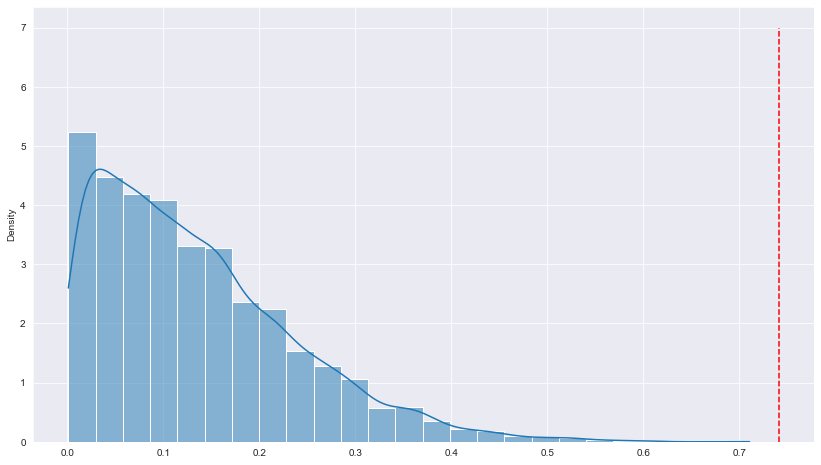

In [8]:
ax = sns.histplot(diferencas_medias_amostras, kde=True, stat="density", bins=25)
ax.figure.set_size_inches(14, 8)
ax.vlines(x=diferenca_medias_real, ymin=0, ymax=7, colors='red', linestyles='dashed')
ax

<font color='red'>**Resposta:**</font>

A partir do resultado do teste de hipótese por simulação, analisando-se as diferenças absolutas das médias dos dados sintéticos em relação à observada, conclui-se que a hipótese nula ($H_{0}$) de que a média do número de sucessos obtidos pela rota "Disappointment Cleaver" é igual à média das demais rotas (conjuntamente) pode ser descartada.

### b)

___

Obtenha o estimador de máxima verossimilhança de $\alpha$ e $\beta$ considerando o modelo proposto. Dica: Use a função $\textsf{optim}$ do $\textbf{\textsf{R}}$ para achar o ponto que maximiza a log-verossimilhança.

Definindo e minimizando a função negativa de log-verossimilhança (na prática, é o mesmo que maximizar a função positiva).

In [9]:
def menos_log_verossimilhanca(parametros):
    alfa, beta = parametros

    lambdas = np.exp(alfa + beta * dados.Temperatura)
    log_verossimilhanca = np.sum(poisson.logpmf(dados.Sucessos, lambdas))

    return -1 * log_verossimilhanca

# Minimiza a função negativa de log verossimilhanca
emv = minimize(menos_log_verossimilhanca, np.array([0, 0]))

# Obtem e imprime os valores de alfa e beta
emv_alfa = emv.x[0]
emv_beta = emv.x[1]
print(f"alfa: {emv_alfa:0.4f}")
print(f"beta: {emv_beta:0.4f}")

alfa: 0.8345
beta: 0.0236


Comparando o resultado da maximização da função de log-verossimilhança com os valores de alfa e beta gerados pela biblioteca *statsmodels*.

In [10]:
# Ajusta o modelo proposto
modelo_poisson = smf.poisson(formula="Sucessos ~ Temperatura", data=dados).fit()

# Imprime os valores
print(f"alfa: {modelo_poisson.params[0]:0.4f}")
print(f"beta: {modelo_poisson.params[1]:0.4f}")

Optimization terminated successfully.
         Current function value: 3.017568
         Iterations 4
alfa: 0.8345
beta: 0.0236


<font color='red'>**Resposta:**</font>

Considerando-se o modelo proposto, o estimador de máxima verossimilhança para $\alpha$ é 0,8345 e $\beta$ é 0,0236.

### c)

___

Estime a distribuição de probabilidade do número de sucessos previstos para um dia em que a temperatura seja de 15 graus.

Gerando dados sintéticos com os parâmetros obtidos na letra b) e temperatura igual a 15ºC.

In [11]:
amostra = pd.Series(poisson.rvs(mu=np.exp(emv_alfa + emv_beta * 15), size=10000, random_state=SEED))

Exibindo a tabela de distribuição de probabilidade do número de sucessos previstos com os parâmetros utilizados.

In [12]:
distribuicao_prob = pd.DataFrame((amostra.value_counts(normalize=True) * 100), columns=["Probabilidades (%)"])
distribuicao_prob.reset_index(inplace=True)
distribuicao_prob = distribuicao_prob.pivot_table("index", columns="index")
distribuicao_prob = distribuicao_prob.rename_axis("Sucessos", axis=1)
distribuicao_prob

Sucessos,0,1,2,3,4,5,6,7,8,9,10,11,12
Probabilidades (%),3.68,12.36,20.4,22.13,18.25,11.99,6.4,3.02,1.2,0.39,0.15,0.02,0.01


<font color='red'>**Resposta:**</font>

A tabela acima mostra a distribuição de probabilidade de sucessos previstos segundo a amostra gerada, considerando-se a temperatura de 15ºC, e $\alpha$ e $\beta$ do modelo ajustado na letra b).

### d)

___

Construa um intervalo de confiança de 95% para $exp(\beta)$ a partir do método de bootstrap não paramétrico. Interprete o resultado considerando o contexto dos dados. Dica: calcule o aumento percentual da média esperada quando a temperatura aumenta em 1 grau Celsius.

Executando o bootstrap paramétrico 10.000 vezes (N) para o modelo ajustado na letra b) e construindo o intervalo de confiança para os $exp(\beta)$ obtidos na simulação.

In [13]:
lista_exp_beta = []

for _ in range(N):
    # Gera a reamostragem com reposição a partir dos dados originais (bootstrap não paramétrico)
    amostra = dados.sample(frac=1, replace=True)
    # Define a variável independente para ajuste dos novos modelos (necessário para o statsmodels)
    X = sm.add_constant(amostra.Temperatura)
    # Define a variável dependente
    y = amostra.Sucessos.to_list()
    # Ajusta o modelo da amostra, calcula exp(beta) com os parâmetros do novo modelo e armazena o valor
    modelo_amostra = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    lista_exp_beta.append(np.exp(modelo_amostra.params[1]))

Exibindo a tabela com o intervalo de confiança de 95%.

In [14]:
ic_exp_beta = pd.DataFrame(np.quantile(lista_exp_beta, q=[0.025, 0.975]))
ic_exp_beta = ic_exp_beta.pivot_table(0, columns=ic_exp_beta.index)
ic_exp_beta.columns = ["2.5%", "97.5%"]
ic_exp_beta.index = ["exp(beta)"]
ic_exp_beta = ic_exp_beta.rename_axis("Intervalo", axis=1)
ic_exp_beta

Intervalo,2.5%,97.5%
exp(beta),1.012643,1.035039


<font color='red'>**Resposta:**</font>

Pelo intervalo de confiança encontrado no boostrap não paramétrico, o aumento de 1 grau na temperatura implica em um acréscimo entre 1,3% e 3,5% no número de sucessos, a um nível de confiança de 95%, considerando-se que $exp(\beta)$ representa justamente esse crescimento.

### e)

___

Faça um diagnóstico do modelo via simulação. Para tanto, gere dados sintéticos usando o modelo obtido no item $\textsf{b)}$, ajuste um novo modelo sobre os dados sintéticos e calcule o Erro Quadrático Médio (MSE). Repita esse procedimento 10000 vezes e compare os MSEs gerados com aquele do modelo obtido em $\textsf{b)}$. Comente os resultados.

Executando a simulação 10.000 (N) vezes com dados sintéticos e ajustados em novos modelos, e construindo o intervalo de confiança para os MSE obtidos na simulação.

In [15]:
lista_mse = []
# Define a variável independente para ajuste dos novos modelos (necessário para o statsmodels)
X = sm.add_constant(dados.Temperatura)
# Define os lambdas baseados no modelo ajustado da letra b)
lambdas_previstos = modelo_poisson.predict()
for _ in range(N):
    # Gera a amostra
    amostra_sucessos = poisson.rvs(mu=lambdas_previstos, size=dados.shape[0])
    # Ajusta o modelo
    modelo_amostra = sm.GLM(amostra_sucessos, X, family=sm.families.Poisson()).fit()
    # Calcula e armazena os MSE
    residuos = amostra_sucessos - modelo_amostra.predict()
    lista_mse.append(np.mean(residuos ** 2))

Exibindo a tabela com o intervalo de confiança de 95%.

In [16]:
ic_mse = pd.DataFrame(np.quantile(lista_mse, q=[0.025, 0.975]))
ic_mse = ic_mse.pivot_table(0, columns=ic_mse.index)
ic_mse.columns = ["2.5%", "97.5%"]
ic_mse.index = ["MSE"]
ic_mse = ic_mse.rename_axis("Intervalo", axis=1)
ic_mse

Intervalo,2.5%,97.5%
MSE,2.419842,2.787038


Obtendo o MSE do modelo ajustado da letra b).

In [17]:
residuos_originais = dados.Sucessos - modelo_poisson.predict()
mse = (residuos_originais ** 2).mean()

print(f"MSE do modelo da letra b): {mse}")

MSE do modelo da letra b): 11.200680062990962


<font color='red'>**Resposta:**</font>

Considerando-se que o valor do MSE para o modelo original ajustado na letra b) está muito fora do intervalo de confiança obtido na simulação com dados sintéticos, pode-se dizer que os dados originais observados não foram gerados pelo modelo ajustado da letra b).

## Questão bônus


Use o método de integração por Monte Carlo para estimar o volume de uma elipsoide definida por $$\frac{x^{2}}{2} + \frac{y^{2}}{3} + \frac{z^{2}}{4} = 1.$$

Calculando o volume da elipsoide.

In [18]:
# Ajusta o tamanho da amostra
tam_amostra = 100000

# Define os denominadores na equação que dão a forma da elipsoide
a = 2
b = 3
c = 4

# Define as coordenadas aleatórias
np.random.seed(SEED)
x = np.random.uniform(-a, a, tam_amostra)
y = np.random.uniform(-b, b, tam_amostra)
z = np.random.uniform(-c, c, tam_amostra)

# Calcula as distâncias das coordenadas segundo a fórmula
distancia = (x / a) ** 2 + (y / b) ** 2 + (z / c) ** 2

# Cria o dataframe com os dados da elipsoide
dados_elipsoide = pd.DataFrame(np.stack((x, y, z, distancia), axis=-1))
dados_elipsoide.columns = ["x", "y", "z", "distancia"]
dados_elipsoide["dentro"] = dados_elipsoide.distancia.apply(lambda dist: 1 if dist < 1 else 0)

# Calcula o volume da elipsoide
partes = 8 * a * b * c
dentro = dados_elipsoide.query("dentro == 1").dentro.count()
proporcao = dentro / tam_amostra
volume = partes * proporcao

# Imprime o volume estimado pela simulação e o analítico
print("Volume simulação:", volume)
print("Volume analítico:", (4/3) * np.pi * a * b * c)

Volume simulação: 100.60224000000001
Volume analítico: 100.53096491487338


Exibindo no gráfico os pontos nas coordenadas obtidos pela integração por simulação de Monte Carlo.

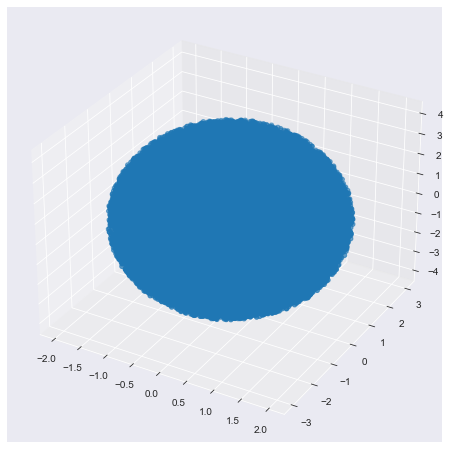

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(14, 8)
dados_scatter = dados_elipsoide.query("dentro == 1")
ax.scatter(dados_scatter.x, dados_scatter.y, dados_scatter.z)
plt.show()

<font color='red'>**Resposta:**</font>

O volume da elipsoide obtido pela integração por Monte Carlo, com uma amostra de tamanho 100.000, é de 100,60. Calculando-se analiticamente, pela fórmula $\frac{4}{3} \pi abc$, chegou-se ao volume de 100.53.